

# Computing a covariance matrix

Many methods in MNE, including source estimation and some classification
algorithms, require covariance estimations from the recordings.
In this tutorial we cover the basics of sensor covariance computations and
construct a noise covariance matrix that can be used when computing the
minimum-norm inverse solution. For more information, see
`minimum_norm_estimates`.


In [ ]:
# License: BSD-3-Clause
# Copyright the MNE-Python contributors.

In [3]:
import mne
from mne.datasets import sample

Source estimation method such as MNE require a noise estimations from the
recordings. In this tutorial we cover the basics of noise covariance and
construct a noise covariance matrix that can be used when computing the
inverse solution. For more information, see `minimum_norm_estimates`.



In [4]:
data_path = sample.data_path()
raw_empty_room_fname = data_path / "MEG" / "sample" / "ernoise_raw.fif"
raw_empty_room = mne.io.read_raw_fif(raw_empty_room_fname)
raw_fname = data_path / "MEG" / "sample" / "sample_audvis_raw.fif"
raw = mne.io.read_raw_fif(raw_fname)
raw.set_eeg_reference("average", projection=True)
raw.info["bads"] += ["EEG 053"]  # bads + 1 more

Opening raw data file C:\Users\ABC\mne_data\MNE-sample-data\MEG\sample\ernoise_raw.fif...
Isotrak not found
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 19800 ... 85867 =     32.966 ...   142.965 secs
Ready.
Opening raw data file C:\Users\ABC\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
EEG channel type selected for re-referencing
Adding average EEG reference projection.
1 projection items deactivated


The definition of noise depends on the paradigm. In MEG it is quite common
to use empty room measurements for the estimation of sensor noise. However if
you are dealing with evoked responses, you might want to also consider
resting state brain activity as noise.
First we compute the noise using empty room recording. Note that you can also
use only a part of the recording with tmin and tmax arguments. That can be
useful if you use resting state as a noise baseline. Here we use the whole
empty room recording to compute the noise covariance (``tmax=None`` is the
same as the end of the recording, see :func:`mne.compute_raw_covariance`).

Keep in mind that you want to match your empty room dataset to your
actual MEG data, processing-wise. Ensure that filters
are all the same and if you use ICA, apply it to your empty-room and subject
data equivalently. In this case we did not filter the data and
we don't use ICA. However, we do have bad channels and projections in
the MEG data, and, hence, we want to make sure they get stored in the
covariance object.



In [3]:
raw_empty_room.info["bads"] = [bb for bb in raw.info["bads"] if "EEG" not in bb]
raw_empty_room.add_proj(
    [pp.copy() for pp in raw.info["projs"] if "EEG" not in pp["desc"]]
)

noise_cov = mne.compute_raw_covariance(raw_empty_room, tmin=0, tmax=None)

3 projection items deactivated
Using up to 550 segments
Number of samples used : 66000
[done]


Now that you have the covariance matrix in an MNE-Python object you can
save it to a file with :func:`mne.write_cov`. Later you can read it back
using :func:`mne.read_cov`.

You can also use the pre-stimulus baseline to estimate the noise covariance.
First we have to construct the epochs. When computing the covariance, you
should use baseline correction when constructing the epochs. Otherwise the
covariance matrix will be inaccurate. In MNE this is done by default, but
just to be sure, we define it here manually.



In [4]:
events = mne.find_events(raw)
epochs = mne.Epochs(
    raw,
    events,
    event_id=1,
    tmin=-0.2,
    tmax=0.5,
    baseline=(-0.2, 0.0),
    decim=3,  # we'll decimate for speed
    verbose="error",
)  # and ignore the warning about aliasing

320 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


Note that this method also attenuates any activity in your
source estimates that resemble the baseline, if you like it or not.



In [5]:
noise_cov_baseline = mne.compute_covariance(epochs, tmax=0)

Loading data for 72 events and 421 original time points (prior to decimation) ...
0 bad epochs dropped
Computing rank from data with rank=None
    Using tolerance 3.7e-09 (2.2e-16 eps * 305 dim * 5.4e+04  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Using tolerance 1.8e-11 (2.2e-16 eps * 59 dim * 1.4e+03  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 projector
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 2952
[done]


## Plot the covariance matrices

Try setting proj to False to see the effect. Notice that the projectors in
epochs are already applied, so ``proj`` parameter has no effect.



    Created an SSP operator (subspace dimension = 3)
Computing rank from covariance with rank=None
    Using tolerance 1.2e-15 (2.2e-16 eps * 102 dim * 0.052  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 203 dim * 2.2  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors


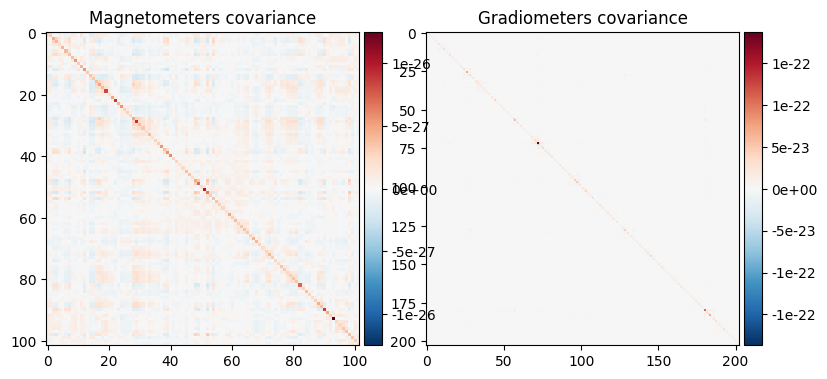

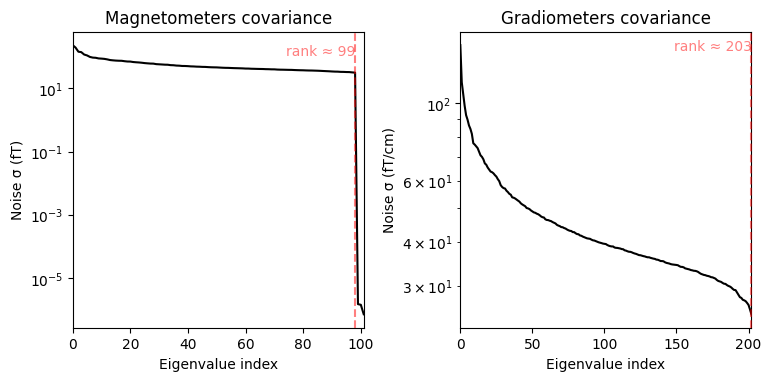

    Created an SSP operator (subspace dimension = 4)
Computing rank from covariance with rank=None
    Using tolerance 2.2e-14 (2.2e-16 eps * 102 dim * 0.96  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.9e-13 (2.2e-16 eps * 203 dim * 4.1  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 8.4e-14 (2.2e-16 eps * 59 dim * 6.4  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 0 projectors


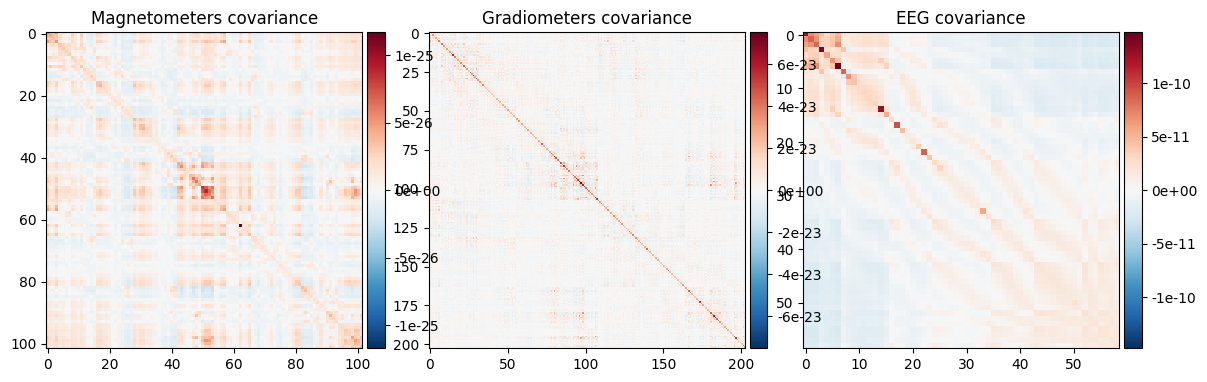

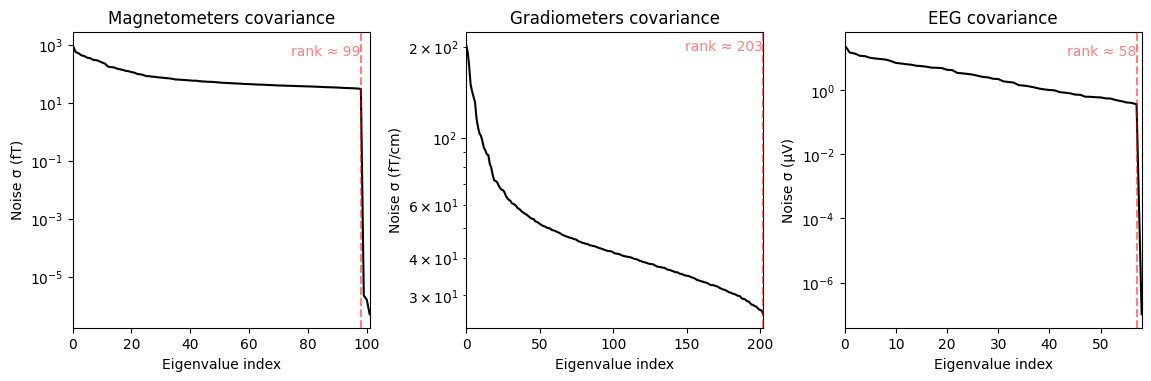

(<Figure size 1140x370 with 6 Axes>, <Figure size 1140x370 with 3 Axes>)

In [6]:
noise_cov.plot(raw_empty_room.info, proj=True)
noise_cov_baseline.plot(epochs.info, proj=True)


## How should I regularize the covariance matrix?

The estimated covariance can be numerically
unstable and tends to induce correlations between estimated source amplitudes
and the number of samples available. The MNE manual therefore suggests to
regularize the noise covariance matrix (see
`cov_regularization_math`), especially if only few samples are
available. Unfortunately it is not easy to tell the effective number of
samples, hence, to choose the appropriate regularization.
In MNE-Python, regularization is done using advanced regularization methods
described in :footcite:t:`EngemannGramfort2015`. For this the ``'auto'`` option
can be used. With this option, cross-validation will be used to learn the
optimal regularization:



In [7]:
noise_cov_reg = mne.compute_covariance(epochs, tmax=0.0, method="auto", rank=None)

Loading data for 72 events and 421 original time points (prior to decimation) ...
Computing rank from data with rank=None
    Using tolerance 3.7e-09 (2.2e-16 eps * 305 dim * 5.4e+04  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Using tolerance 1.8e-11 (2.2e-16 eps * 59 dim * 1.4e+03  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 projector
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using SHRUNK
Done.
Estimating covariance using DIAGONAL_FIXED
    MAG regularization : 0.1
    GRAD regularization : 0.1
    EEG regularization : 0.1
Done.
Estimating covariance using EMPIRICAL
Done.
Using cross-validation to select the best estimator.
    MAG regularization : 0.1
    GRAD reg

This procedure evaluates the noise covariance quantitatively by how well it
whitens the data using the
negative log-likelihood of unseen data. The final result can also be visually
inspected.
Under the assumption that the baseline does not contain a systematic signal
(time-locked to the event of interest), the whitened baseline signal should
be follow a multivariate Gaussian distribution, i.e.,
whitened baseline signals should be between -1.96 and 1.96 at a given time
sample.
Based on the same reasoning, the expected value for the :term:`global field
power (GFP) <GFP>` is 1 (calculation of the GFP should take into account the
true degrees of freedom, e.g. ``ddof=3`` with 2 active SSP vectors):



NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 8.4e-14 (2.2e-16 eps * 59 dim * 6.4  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 projector
Computing rank from covariance with rank=None
    Using tolerance 1.8e-13 (2.2e-16 eps * 203 dim * 4  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.1e-14 (2.2e-16 eps * 102 dim * 0.91  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 3 projectors
    Created an SSP operator (subspace dimension = 4)
Computing rank from covariance with rank={'eeg': 58, 'grad': 203, 'mag': 99, 'meg': 302}
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
    Creat

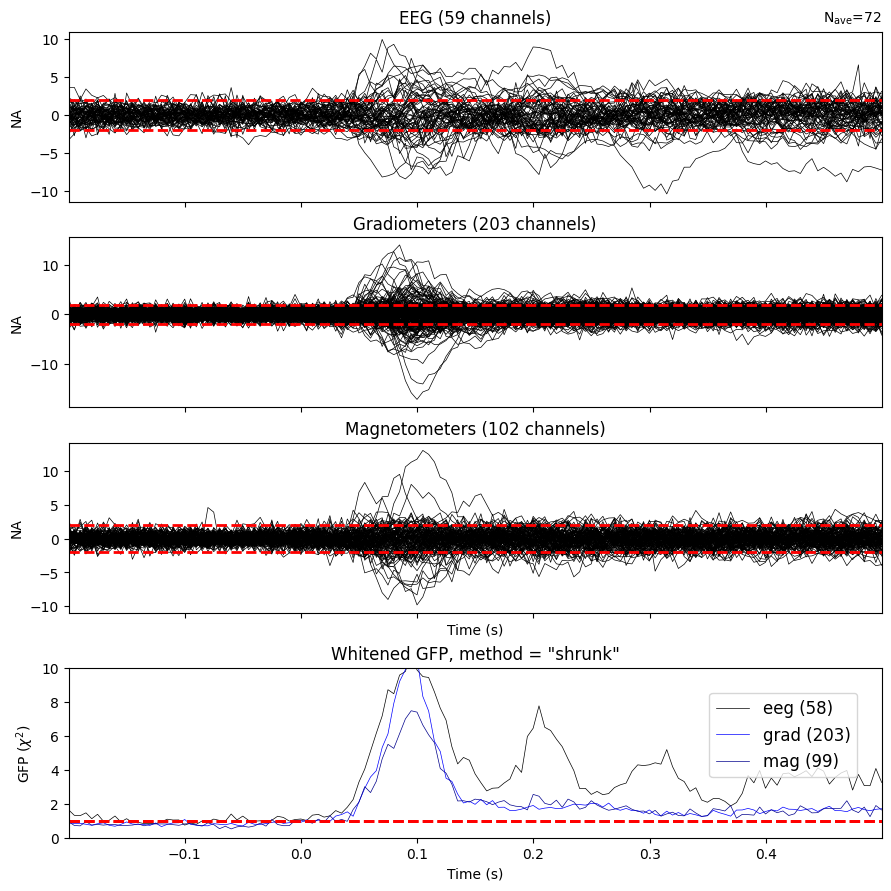

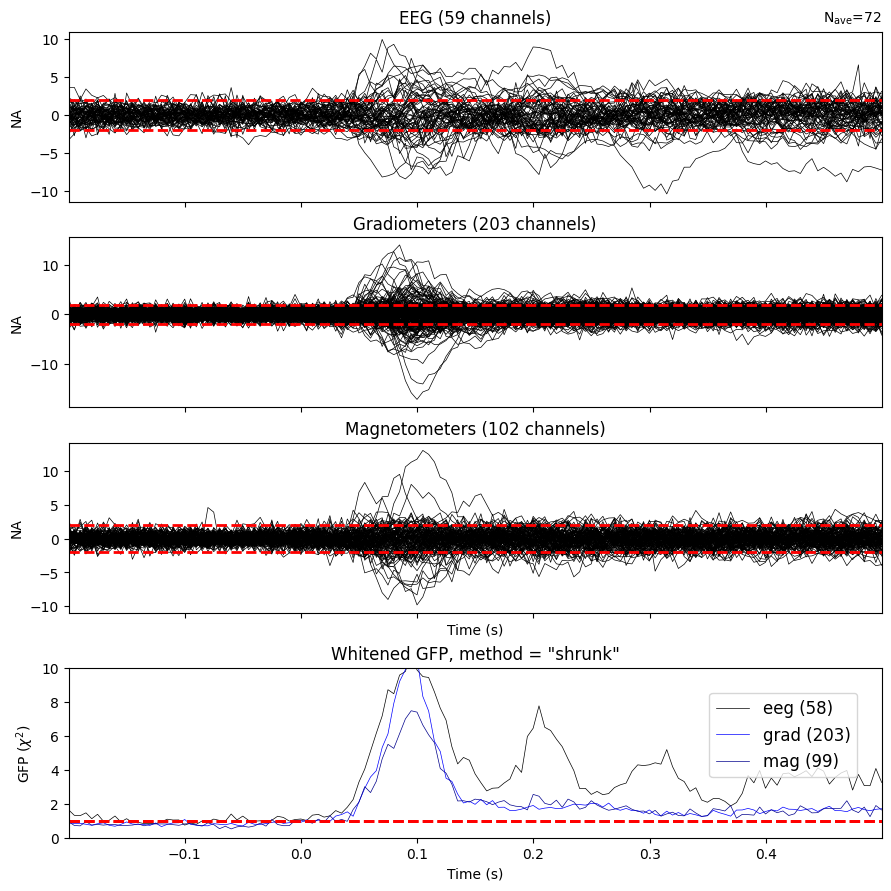

In [8]:
evoked = epochs.average()
evoked.plot_white(noise_cov_reg, time_unit="s")

This plot displays both, the whitened evoked signals for each channels and
the whitened :term:`GFP`. The numbers in the GFP panel represent the
estimated rank of the data, which amounts to the effective degrees of freedom
by which the squared sum across sensors is divided when computing the
whitened :term:`GFP`. The whitened :term:`GFP` also helps detecting spurious
late evoked components which can be the consequence of over- or
under-regularization.

Note that if data have been processed using signal space separation
(SSS) :footcite:`TauluEtAl2005`,
gradiometers and magnetometers will be displayed jointly because both are
reconstructed from the same SSS basis vectors with the same numerical rank.
This also implies that both sensor types are not any longer statistically
independent.
These methods for evaluation can be used to assess model violations.
Additional
introductory materials can be found [here](https://goo.gl/ElWrxe).

For expert use cases or debugging the alternative estimators can also be
compared (see `ex-evoked-whitening`):



Loading data for 72 events and 421 original time points (prior to decimation) ...
Computing rank from data with rank=None
    Using tolerance 3.7e-09 (2.2e-16 eps * 305 dim * 5.4e+04  max singular value)
    Estimated rank (mag + grad): 302
    MEG: rank 302 computed from 305 data channels with 3 projectors
    Using tolerance 1.8e-11 (2.2e-16 eps * 59 dim * 1.4e+03  max singular value)
    Estimated rank (eeg): 58
    EEG: rank 58 computed from 59 data channels with 1 projector
    Created an SSP operator (subspace dimension = 4)
    Setting small MEG eigenvalues to zero (without PCA)
    Setting small EEG eigenvalues to zero (without PCA)
Reducing data rank from 364 -> 360
Estimating covariance using EMPIRICAL
Done.
Estimating covariance using SHRUNK
Done.
Using cross-validation to select the best estimator.
Number of samples used : 2952
log-likelihood on unseen data (descending order):
   shrunk: -1769.292
   empirical: -1797.005
[done]
NOTE: pick_types() is a legacy function. New c

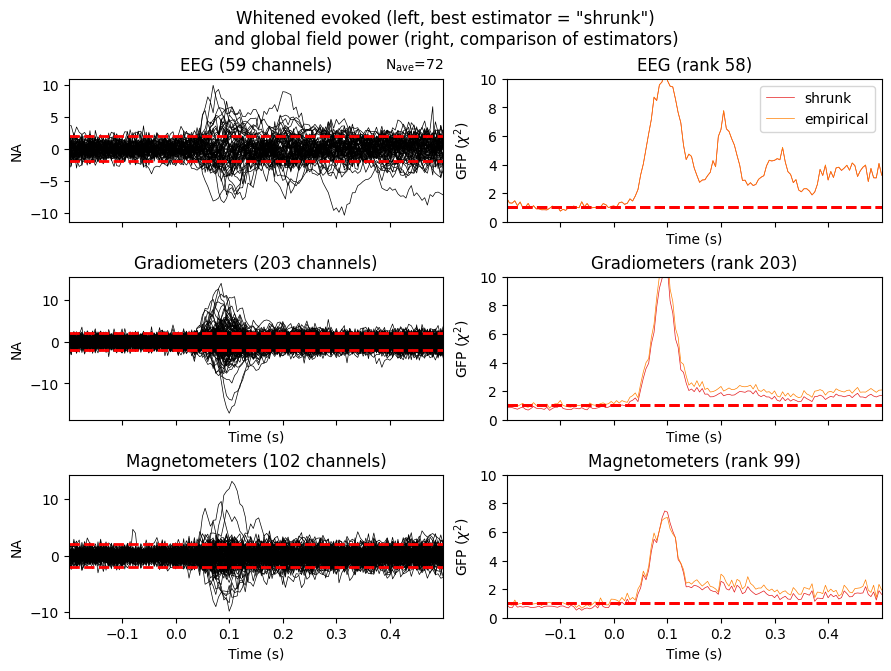

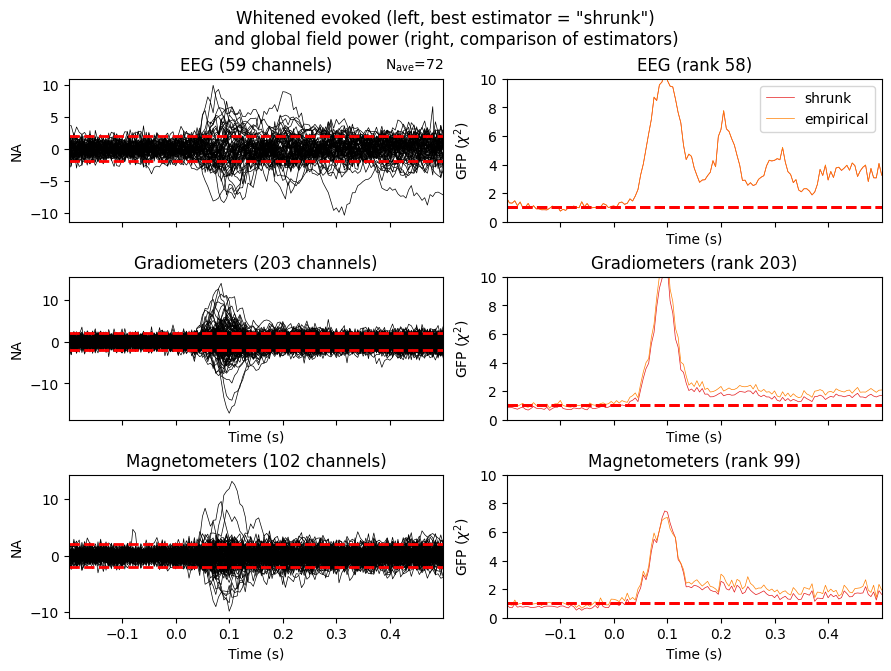

In [9]:
noise_covs = mne.compute_covariance(
    epochs, tmax=0.0, method=("empirical", "shrunk"), return_estimators=True, rank=None
)
evoked.plot_white(noise_covs, time_unit="s")

This will plot the whitened evoked for the optimal estimator and display the
:term:`GFP` for all estimators as separate lines in the related panel.

Finally, let's have a look at the difference between empty room and
event related covariance, hacking the ``"method"`` option so that their types
are shown in the legend of the plot.



Removing projector <Projection | Average EEG reference, active : True, n_channels : 59>
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Computing rank from covariance with rank=None
    Using tolerance 1.9e-13 (2.2e-16 eps * 203 dim * 4.1  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 2.2e-14 (2.2e-16 eps * 102 dim * 0.96  max singular value)
    Estimated rank (mag): 99
    MAG: rank 99 computed from 102 data channels with 3 projectors
Computing rank from covariance with rank=None
    Using tolerance 9.7e-14 (2.2e-16 eps * 203 dim * 2.2  max singular value)
    Estimated rank (grad): 203
    GRAD: rank 203 computed from 203 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.2e-15 (2.2e-16 eps * 102 dim * 0.052  max singular value)
    Estimated rank (mag): 99
    MAG: ra

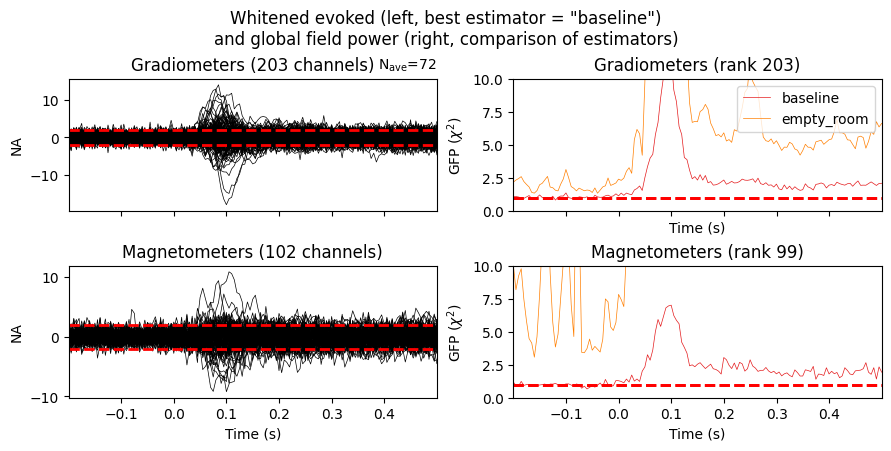

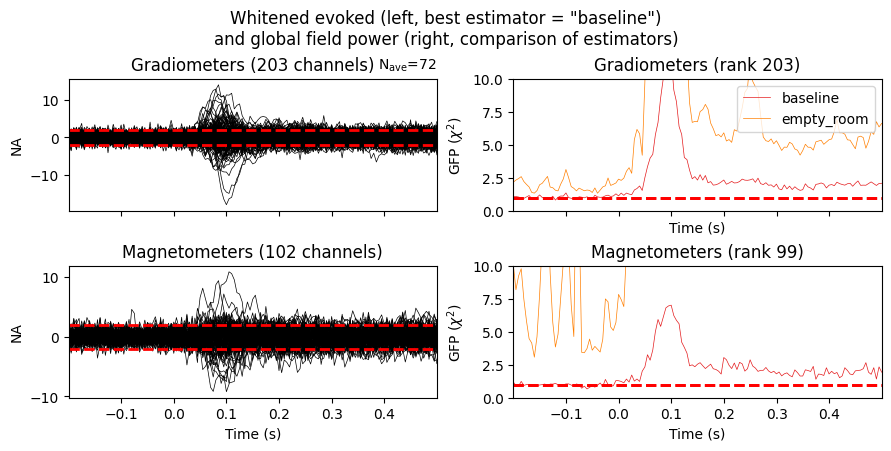

In [10]:
evoked_meg = evoked.copy().pick("meg")
noise_cov["method"] = "empty_room"
noise_cov_baseline["method"] = "baseline"
evoked_meg.plot_white([noise_cov_baseline, noise_cov], time_unit="s")

Based on the negative log-likelihood, the baseline covariance
seems more appropriate. Improper regularization can lead to overestimation of
source amplitudes, see :footcite:p:`EngemannGramfort2015` for more
information and examples.

## References

.. footbibliography::

